In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
from flash_attn import flash_attn_func

from library import StockUniverse, FactorLibrary, MarketInfo, FileLoader
import pandas as pd
from torch.utils.data import Dataset
import numpy as np
import gc
import torch
from torch.utils.data import DataLoader
from library import FactorLibrary2

📂 讀取: Y:\因子回測_江建彰\因子庫.pkl


In [2]:
stock_universe = 'TWSE'
flib = FactorLibrary2(path=f'Y:\因子回測_江建彰\因子庫{stock_universe}.pkl')

📂 讀取: Y:\因子回測_江建彰\因子庫TWSE.pkl


In [3]:
class AllDayFactorDataset(Dataset):
    def __init__(self, stock_universe='TWSE'):
        self.multi_df = FileLoader.load(f'Y:\因子回測_江建彰\因子庫{stock_universe}.pkl')
        self.adj_close_df = pd.read_feather(r'Y:\因子回測_江建彰\補上缺值日頻收盤價.ftr')
        self.stock_list = self.get_stock_list(stock_universe)
        
        self.TPEX_df = MarketInfo.TPEX_norm()
        self.RoR_df = (self.adj_close_df.shift(-5) - self.adj_close_df.shift(-1)) / self.adj_close_df.shift(-1)
        self.RoR_df.dropna(axis=0, inplace=True)


        new_ticker_list = self.multi_df.columns.get_level_values('ticker')
        new_ticker_list = new_ticker_list[~new_ticker_list.duplicated()]

        self.stock_list = new_ticker_list
        self.RoR_df = self.RoR_df[self.stock_list]
        self.adj_close_df = self.adj_close_df[self.stock_list]
        # 這裡所有值都包含當天資訊所以要向後移
        self.restrict_range()
        self.check_validility()

        


        

        #self.tensor_factor = self.factor_to_tensor()
        #self.tensor_market = self.TPEX_df.values
        #self.tensor_return = self.RoR_df[self.stock_list]
        #print(f'stock list : {len(self.stock_list)}')
    def check_validility(self):
        ticker_list1 = self.stock_list
        ticker_list2 = self.RoR_df.columns
        ticker_list3 = self.multi_df.columns.get_level_values('ticker')
        ticker_list3 = ticker_list3[~ticker_list3.duplicated()]
        assert len(ticker_list1)==len(ticker_list2)==len(ticker_list3)
        
        BOOL = True
        for i in range(len(ticker_list1)):
            if not (ticker_list1[i]==ticker_list2[i]==ticker_list3[i]):
                BOOL = False
        assert BOOL==True
        

        factor_list = self.multi_df.columns.get_level_values('factor')
        factor_list = factor_list[~factor_list.duplicated()]
        BOOL = True
        for factor_name in factor_list:
            ticker_list4 = self.multi_df.loc[ : , factor_name].columns
            for i in range(len(ticker_list1)):
                if ticker_list1[i]!=ticker_list4[i]:
                    BOOL = False
        assert BOOL==True
        

    def factor_to_tensor(self):
        factor_num = len(self.multi_df.columns.get_level_values('factor').unique())
        time = len(self.TPEX_df.index)
        

       
            
            
                
        """
        剔除因子缺失太多的股票
        
        new_stock_list = []
        for idx, ticker in enumerate(self.stock_list):
            numpy_array = self.multi_df.xs(ticker, axis=1, level='ticker').values
            missing_ratio = np.isnan(numpy_array).sum() / (time*factor_num)
            if(missing_ratio<=0.05):
                new_stock_list.append(ticker)
        self.stock_list = new_stock_list
        """

        """
        轉成向量
        """

        
        factor_name = 'factor1'
        #print(self.multi_df.loc[start_date : end_date, factor_name])

        
        stock_num = len(self.stock_list)
        tensor_factor = np.empty((stock_num, time, factor_num))
        for idx, ticker in enumerate(self.stock_list):
            numpy_array = self.multi_df.xs(ticker, axis=1, level='ticker').ffill().values
            numpy_array = np.nan_to_num(numpy_array, nan=0.0)
            tensor_factor[idx] = numpy_array

        
        
        return tensor_factor

    

    def restrict_range(self, global_start='2020-04-01', global_end='2025-04-09'):
        self.multi_df     = self.multi_df.loc[global_start : global_end]
        self.adj_close_df = self.adj_close_df.loc[global_start : global_end]
        self.TPEX_df      = self.TPEX_df.loc[global_start : global_end]
        self.RoR_df       = self.RoR_df.loc[global_start : global_end]
    
        
        
        
    def get_stock_list(self, stock_univserse):
        if stock_univserse=='TWSE':
            ticker1 = StockUniverse.TWSE() 
        elif stock_univserse=='OTC':
            ticker1 = StockUniverse.OTC()
        elif stock_univserse=='all':
            ticker1 = StockUniverse.all()
            
        
        ticker2 = self.multi_df.columns.get_level_values('ticker')
        ticker3 = self.adj_close_df.columns
        return list(set(ticker1)&set(ticker2)&set(ticker3))


    

In [4]:
class FactorDataset(Dataset):
    def __init__(self, stock_universe='TWSE', mode='train'):
        #multi_df, TPEX_df, RoR_df = self.restrict_data_range(stock_universe, mode)
        self.e = AllDayFactorDataset(stock_universe='TWSE')
        self.stock_list = self.e.stock_list
        multi_df, TPEX_df, RoR_df = self.restrict_data_range(stock_universe, mode)

        
        
        self.tensor_factor = self.get_tensor_factors(multi_df)
        #self.tesnor_factor = self.tesnor_factor.transpose(1,0,2) # (stock, time, factor) -> (time, stock, factor)
        self.tensor_market = TPEX_df.values
        self.tensor_return = RoR_df.values

        self.tensor_factor = self.transform_to_tensor(self.tensor_factor)
        self.tensor_market = self.transform_to_tensor(self.tensor_market)
        self.tensor_return = self.transform_to_tensor(self.tensor_return)




        returns = self.tensor_return.clone()  # shape: [122, 887]
        mean = returns.mean(dim=1, keepdim=True)   # 每天的均值 shape: [122, 1]
        std = returns.std(dim=1, keepdim=True)     # 每天的標準差 shape: [122, 1]
        # 防止除以 0
        std = torch.where(std == 0, torch.tensor(1.0), std)
        self.tensor_return_norm = (returns - mean) / std  # shape: [122, 887]


        self.T = self.tensor_market.shape[0]
        self.lookback = 8
        self.valid_length = self.T - self.lookback

        

        self.TPEX_df = TPEX_df
        self.RoR_df = RoR_df
        
        
    def transform_to_tensor(self, numpy_array):
        float32_np = numpy_array.astype(np.float32)
        return torch.from_numpy(float32_np)

    def get_tensor_factors(self, multi_df):
        stock_num = len(multi_df.columns.get_level_values('ticker').unique())
        time = len(multi_df.index)
        factor_num = len(multi_df.columns.get_level_values('factor').unique())
        
        tensor_factor = np.empty((stock_num, time, factor_num))
        for idx, ticker in enumerate(self.stock_list):
            numpy_array = multi_df.xs(ticker, axis=1, level='ticker').values
            tensor_factor[idx] = numpy_array

        assert not np.isnan(tensor_factor).any()

        return tensor_factor
        

    def restrict_data_range(self, stock_universe, mode):
        e = AllDayFactorDataset(stock_universe)
        train_ratio, valid_ratio, test_ratio = 0.8, 0.1, 0.1
        total_num = len(self.e.TPEX_df)
        train_num = int(total_num*train_ratio)
        valid_num = int(total_num*valid_ratio)
        test_num  = total_num - (train_num+valid_num)
        if mode=='train':
            start_idx, end_idx = 0, train_num
        elif mode=='valid':
            start_idx, end_idx = train_num, train_num + valid_num
        elif mode=='test': 
            start_idx, end_idx = train_num + valid_num, total_num

        e = AllDayFactorDataset(stock_universe)
        return self.e.multi_df.iloc[start_idx : end_idx], \
               self.e.TPEX_df.iloc[start_idx : end_idx], \
               self.e.RoR_df.iloc[start_idx : end_idx]
    def __len__(self):
        return self.valid_length
        
    def __getitem__(self, idx):
        X = self.tensor_factor[ : , idx:idx+self.lookback, : ] # (stock, time, factor)
        M = self.tensor_market[idx+self.lookback-1, : ]
        R = self.tensor_return[idx+self.lookback-1, : ]
        R_norm = self.tensor_return_norm[idx+self.lookback-1, : ]
        return X, M, R, R_norm
        

#t = FactorDataset(stock_universe='TWSE', mode='train')

In [5]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
train_set = FactorDataset(stock_universe='TWSE', mode='train')
valid_set = FactorDataset(stock_universe='TWSE', mode='valid')
test_set = FactorDataset(stock_universe='TWSE', mode='test')

⚡ 快取使用: Y:\因子回測_江建彰\因子庫TWSE.pkl
⚡ 快取使用: Y:\因子回測_江建彰\因子庫TWSE.pkl
⚡ 快取使用: Y:\因子回測_江建彰\因子庫TWSE.pkl
⚡ 快取使用: Y:\因子回測_江建彰\因子庫TWSE.pkl
⚡ 快取使用: Y:\因子回測_江建彰\因子庫TWSE.pkl
⚡ 快取使用: Y:\因子回測_江建彰\因子庫TWSE.pkl
⚡ 快取使用: Y:\因子回測_江建彰\因子庫TWSE.pkl
⚡ 快取使用: Y:\因子回測_江建彰\因子庫TWSE.pkl
⚡ 快取使用: Y:\因子回測_江建彰\因子庫TWSE.pkl


In [6]:
train_set.e.multi_df

factor      factor_0                                                    \
ticker          1101      1102      1103      1104      1108      1109   
Date                                                                     
2020-04-01 -0.673939 -0.455914 -0.600366 -0.193277  1.754857 -0.967506   
2020-04-06 -0.327203 -0.146773 -0.556454 -0.166725  1.027622 -0.758691   
2020-04-07  0.098016  1.224380  0.101407  0.234013  0.153450 -0.239635   
2020-04-08 -0.319991  0.674528  0.049169  0.289316 -0.621626 -0.291409   
2020-04-09 -0.232543  0.327937  0.066867  0.110226 -0.713421 -0.238935   
...              ...       ...       ...       ...       ...       ...   
2025-04-01  0.340768  0.900310  0.464735  0.591395  0.006090  0.103580   
2025-04-02  1.004445  0.171334 -0.185994  0.407952 -0.374743 -0.487857   
2025-04-07  1.361418  1.361418  1.182799  1.361418  1.356861  1.361418   
2025-04-08  1.427229  1.427229  1.427229  1.427229  1.427229  1.427229   
2025-04-09  1.450276  1.450276  1.450276  1.450276  1.450276  1.450276   

factor                                              ... factor_185            \
ticker          1110      1201      1203      1210  ...       9939      9940   
Date                                                ...                        
2020-04-01 -1.611826  1.346149 -0.139294  0.163777  ...   0.066802  0.072487   
2020-04-06 -2.130461 -0.347443 -1.021574 -0.870032  ...   0.082190  0.082626   
2020-04-07 -1.987577 -0.916866 -0.984516 -0.930563  ...   0.068940  0.073008   
2020-04-08 -1.360423 -0.868599 -0.781669 -0.766940  ...   0.055604  0.033972   
2020-04-09 -0.264998 -0.536980 -0.391901 -0.507913  ...   0.049386  0.022256   
...              ...       ...       ...       ...  ...        ...       ...   
2025-04-01  1.969913  0.432038  0.489601  0.704419  ...  -1.143642 -0.416881   
2025-04-02  1.728988  1.728988  1.096996  1.728988  ...  -0.992188  0.137274   
2025-04-07  1.361418  1.361418  1.361418  1.361418  ...  -0.008507  0.000583   
2025-04-08  1.427229  1.427229  1.427229  1.427229  ...  -0.027256 -0.034378   
2025-04-09  1.167629  1.378374  1.450276  1.450276  ...  -0.067628  0.004631   

factor                                                                  \
ticker          9941      9942      9943      9944      9945      9946   
Date                                                                     
2020-04-01  0.058731  0.070173  0.068826  0.072342  0.041585  0.107296   
2020-04-06  0.078126  0.092643  0.096279  0.101995  0.070161  0.119151   
2020-04-07  0.074640  0.075921  0.077645  0.111064  0.090337  0.051750   
2020-04-08  0.036535  0.031070  0.035563  0.098852  0.055969 -0.003307   
2020-04-09  0.040502  0.031352  0.046665  0.097971  0.031984  0.103135   
...              ...       ...       ...       ...       ...       ...   
2025-04-01 -0.168819  0.081369  0.144244  1.824791 -0.507640 -1.891102   
2025-04-02  1.358135  0.246138  0.452394  1.848424 -0.107221 -1.861662   
2025-04-07  0.073191  0.038328  0.005722  0.076073  0.036290  0.023162   
2025-04-08 -0.011736 -0.036078 -0.000374  0.047075  0.018541  0.000232   
2025-04-09 -0.126421 -0.091972 -0.039853 -0.126421 -0.023461 -0.007847   

factor                          
ticker          9955      9958  
Date                            
2020-04-01  0.074130  0.078821  
2020-04-06  0.100967  0.086217  
2020-04-07  0.089592  0.078324  
2020-04-08  0.017020  0.083563  
2020-04-09  0.003805  0.043055  
...              ...       ...  
2025-04-01  1.824791  0.835318  
2025-04-02  1.848424  1.022157  
2025-04-07  0.076073  0.074417  
2025-04-08  0.104005  0.104005  
2025-04-09  0.156484  0.178677  

[1220 rows x 164982 columns]

In [7]:
M = train_set.e.multi_df

In [8]:
M

factor      factor_0                                                    \
ticker          1101      1102      1103      1104      1108      1109   
Date                                                                     
2020-04-01 -0.673939 -0.455914 -0.600366 -0.193277  1.754857 -0.967506   
2020-04-06 -0.327203 -0.146773 -0.556454 -0.166725  1.027622 -0.758691   
2020-04-07  0.098016  1.224380  0.101407  0.234013  0.153450 -0.239635   
2020-04-08 -0.319991  0.674528  0.049169  0.289316 -0.621626 -0.291409   
2020-04-09 -0.232543  0.327937  0.066867  0.110226 -0.713421 -0.238935   
...              ...       ...       ...       ...       ...       ...   
2025-04-01  0.340768  0.900310  0.464735  0.591395  0.006090  0.103580   
2025-04-02  1.004445  0.171334 -0.185994  0.407952 -0.374743 -0.487857   
2025-04-07  1.361418  1.361418  1.182799  1.361418  1.356861  1.361418   
2025-04-08  1.427229  1.427229  1.427229  1.427229  1.427229  1.427229   
2025-04-09  1.450276  1.450276  1.450276  1.450276  1.450276  1.450276   

factor                                              ... factor_185            \
ticker          1110      1201      1203      1210  ...       9939      9940   
Date                                                ...                        
2020-04-01 -1.611826  1.346149 -0.139294  0.163777  ...   0.066802  0.072487   
2020-04-06 -2.130461 -0.347443 -1.021574 -0.870032  ...   0.082190  0.082626   
2020-04-07 -1.987577 -0.916866 -0.984516 -0.930563  ...   0.068940  0.073008   
2020-04-08 -1.360423 -0.868599 -0.781669 -0.766940  ...   0.055604  0.033972   
2020-04-09 -0.264998 -0.536980 -0.391901 -0.507913  ...   0.049386  0.022256   
...              ...       ...       ...       ...  ...        ...       ...   
2025-04-01  1.969913  0.432038  0.489601  0.704419  ...  -1.143642 -0.416881   
2025-04-02  1.728988  1.728988  1.096996  1.728988  ...  -0.992188  0.137274   
2025-04-07  1.361418  1.361418  1.361418  1.361418  ...  -0.008507  0.000583   
2025-04-08  1.427229  1.427229  1.427229  1.427229  ...  -0.027256 -0.034378   
2025-04-09  1.167629  1.378374  1.450276  1.450276  ...  -0.067628  0.004631   

factor                                                                  \
ticker          9941      9942      9943      9944      9945      9946   
Date                                                                     
2020-04-01  0.058731  0.070173  0.068826  0.072342  0.041585  0.107296   
2020-04-06  0.078126  0.092643  0.096279  0.101995  0.070161  0.119151   
2020-04-07  0.074640  0.075921  0.077645  0.111064  0.090337  0.051750   
2020-04-08  0.036535  0.031070  0.035563  0.098852  0.055969 -0.003307   
2020-04-09  0.040502  0.031352  0.046665  0.097971  0.031984  0.103135   
...              ...       ...       ...       ...       ...       ...   
2025-04-01 -0.168819  0.081369  0.144244  1.824791 -0.507640 -1.891102   
2025-04-02  1.358135  0.246138  0.452394  1.848424 -0.107221 -1.861662   
2025-04-07  0.073191  0.038328  0.005722  0.076073  0.036290  0.023162   
2025-04-08 -0.011736 -0.036078 -0.000374  0.047075  0.018541  0.000232   
2025-04-09 -0.126421 -0.091972 -0.039853 -0.126421 -0.023461 -0.007847   

factor                          
ticker          9955      9958  
Date                            
2020-04-01  0.074130  0.078821  
2020-04-06  0.100967  0.086217  
2020-04-07  0.089592  0.078324  
2020-04-08  0.017020  0.083563  
2020-04-09  0.003805  0.043055  
...              ...       ...  
2025-04-01  1.824791  0.835318  
2025-04-02  1.848424  1.022157  
2025-04-07  0.076073  0.074417  
2025-04-08  0.104005  0.104005  
2025-04-09  0.156484  0.178677  

[1220 rows x 164982 columns]

In [9]:
def get_multidf_shift(n, multi_df):
    # 原始欄位
    old_columns = multi_df.columns
    
    # 重命名：把 factor 改成 factor_shift1
    new_columns = [(f"{fac}_shift{n}", tic) for fac, tic in old_columns]
    
    # 替換 columns
    multi_df.columns = pd.MultiIndex.from_tuples(new_columns, names=["factor", "ticker"])
    return multi_df.shift(n)
    

In [10]:
get_multidf_shift(1, M.copy())

factor     factor_0_shift1                                                    \
ticker                1101      1102      1103      1104      1108      1109   
Date                                                                           
2020-04-01             NaN       NaN       NaN       NaN       NaN       NaN   
2020-04-06       -0.673939 -0.455914 -0.600366 -0.193277  1.754857 -0.967506   
2020-04-07       -0.327203 -0.146773 -0.556454 -0.166725  1.027622 -0.758691   
2020-04-08        0.098016  1.224380  0.101407  0.234013  0.153450 -0.239635   
2020-04-09       -0.319991  0.674528  0.049169  0.289316 -0.621626 -0.291409   
...                    ...       ...       ...       ...       ...       ...   
2025-04-01        0.787299  1.301276  0.656027  0.977337  0.858112  0.724245   
2025-04-02        0.340768  0.900310  0.464735  0.591395  0.006090  0.103580   
2025-04-07        1.004445  0.171334 -0.185994  0.407952 -0.374743 -0.487857   
2025-04-08        1.361418  1.361418  1.182799  1.361418  1.356861  1.361418   
2025-04-09        1.427229  1.427229  1.427229  1.427229  1.427229  1.427229   

factor                                              ... factor_185_shift1  \
ticker          1110      1201      1203      1210  ...              9939   
Date                                                ...                     
2020-04-01       NaN       NaN       NaN       NaN  ...               NaN   
2020-04-06 -1.611826  1.346149 -0.139294  0.163777  ...          0.066802   
2020-04-07 -2.130461 -0.347443 -1.021574 -0.870032  ...          0.082190   
2020-04-08 -1.987577 -0.916866 -0.984516 -0.930563  ...          0.068940   
2020-04-09 -1.360423 -0.868599 -0.781669 -0.766940  ...          0.055604   
...              ...       ...       ...       ...  ...               ...   
2025-04-01  2.033401  0.782021  0.740245  1.218338  ...         -0.900963   
2025-04-02  1.969913  0.432038  0.489601  0.704419  ...         -1.143642   
2025-04-07  1.728988  1.728988  1.096996  1.728988  ...         -0.992188   
2025-04-08  1.361418  1.361418  1.361418  1.361418  ...         -0.008507   
2025-04-09  1.427229  1.427229  1.427229  1.427229  ...         -0.027256   

factor                                                                  \
ticker          9940      9941      9942      9943      9944      9945   
Date                                                                     
2020-04-01       NaN       NaN       NaN       NaN       NaN       NaN   
2020-04-06  0.072487  0.058731  0.070173  0.068826  0.072342  0.041585   
2020-04-07  0.082626  0.078126  0.092643  0.096279  0.101995  0.070161   
2020-04-08  0.073008  0.074640  0.075921  0.077645  0.111064  0.090337   
2020-04-09  0.033972  0.036535  0.031070  0.035563  0.098852  0.055969   
...              ...       ...       ...       ...       ...       ...   
2025-04-01 -0.201171 -0.449170 -0.136460 -0.467771  0.685049 -0.121216   
2025-04-02 -0.416881 -0.168819  0.081369  0.144244  1.824791 -0.507640   
2025-04-07  0.137274  1.358135  0.246138  0.452394  1.848424 -0.107221   
2025-04-08  0.000583  0.073191  0.038328  0.005722  0.076073  0.036290   
2025-04-09 -0.034378 -0.011736 -0.036078 -0.000374  0.047075  0.018541   

factor                                    
ticker          9946      9955      9958  
Date                                      
2020-04-01       NaN       NaN       NaN  
2020-04-06  0.107296  0.074130  0.078821  
2020-04-07  0.119151  0.100967  0.086217  
2020-04-08  0.051750  0.089592  0.078324  
2020-04-09 -0.003307  0.017020  0.083563  
...              ...       ...       ...  
2025-04-01 -0.704371  1.705618  1.313307  
2025-04-02 -1.891102  1.824791  0.835318  
2025-04-07 -1.861662  1.848424  1.022157  
2025-04-08  0.023162  0.076073  0.074417  
2025-04-09  0.000232  0.104005  0.104005  

[1220 rows x 164982 columns]

In [11]:
A_list = [get_multidf_shift(i, M.copy()) for i in range(0,9)]

In [12]:
B = pd.concat(A_list, axis=1)

In [13]:
B

factor     factor_0_shift0                                                    \
ticker                1101      1102      1103      1104      1108      1109   
Date                                                                           
2020-04-01       -0.673939 -0.455914 -0.600366 -0.193277  1.754857 -0.967506   
2020-04-06       -0.327203 -0.146773 -0.556454 -0.166725  1.027622 -0.758691   
2020-04-07        0.098016  1.224380  0.101407  0.234013  0.153450 -0.239635   
2020-04-08       -0.319991  0.674528  0.049169  0.289316 -0.621626 -0.291409   
2020-04-09       -0.232543  0.327937  0.066867  0.110226 -0.713421 -0.238935   
...                    ...       ...       ...       ...       ...       ...   
2025-04-01        0.340768  0.900310  0.464735  0.591395  0.006090  0.103580   
2025-04-02        1.004445  0.171334 -0.185994  0.407952 -0.374743 -0.487857   
2025-04-07        1.361418  1.361418  1.182799  1.361418  1.356861  1.361418   
2025-04-08        1.427229  1.427229  1.427229  1.427229  1.427229  1.427229   
2025-04-09        1.450276  1.450276  1.450276  1.450276  1.450276  1.450276   

factor                                              ... factor_185_shift8  \
ticker          1110      1201      1203      1210  ...              9939   
Date                                                ...                     
2020-04-01 -1.611826  1.346149 -0.139294  0.163777  ...               NaN   
2020-04-06 -2.130461 -0.347443 -1.021574 -0.870032  ...               NaN   
2020-04-07 -1.987577 -0.916866 -0.984516 -0.930563  ...               NaN   
2020-04-08 -1.360423 -0.868599 -0.781669 -0.766940  ...               NaN   
2020-04-09 -0.264998 -0.536980 -0.391901 -0.507913  ...               NaN   
...              ...       ...       ...       ...  ...               ...   
2025-04-01  1.969913  0.432038  0.489601  0.704419  ...         -0.023592   
2025-04-02  1.728988  1.728988  1.096996  1.728988  ...          0.041764   
2025-04-07  1.361418  1.361418  1.361418  1.361418  ...          1.214724   
2025-04-08  1.427229  1.427229  1.427229  1.427229  ...         -0.019540   
2025-04-09  1.167629  1.378374  1.450276  1.450276  ...          0.008608   

factor                                                                  \
ticker          9940      9941      9942      9943      9944      9945   
Date                                                                     
2020-04-01       NaN       NaN       NaN       NaN       NaN       NaN   
2020-04-06       NaN       NaN       NaN       NaN       NaN       NaN   
2020-04-07       NaN       NaN       NaN       NaN       NaN       NaN   
2020-04-08       NaN       NaN       NaN       NaN       NaN       NaN   
2020-04-09       NaN       NaN       NaN       NaN       NaN       NaN   
...              ...       ...       ...       ...       ...       ...   
2025-04-01  0.015413  0.022440  0.013471  0.030102  0.087417  0.021586   
2025-04-02  0.014625  0.090190  0.007788  0.030575  0.090190  0.021468   
2025-04-07 -0.504837  1.790602 -0.162964 -0.012348  1.790602 -0.743591   
2025-04-08 -0.718179  1.410096 -0.116553 -0.057551  1.743454 -0.690271   
2025-04-09  0.040786  0.090051  0.029571  0.028960  0.056549  0.010588   

factor                                    
ticker          9946      9955      9958  
Date                                      
2020-04-01       NaN       NaN       NaN  
2020-04-06       NaN       NaN       NaN  
2020-04-07       NaN       NaN       NaN  
2020-04-08       NaN       NaN       NaN  
2020-04-09       NaN       NaN       NaN  
...              ...       ...       ...  
2025-04-01  0.056166  0.076325  0.087417  
2025-04-02  0.090190  0.009687  0.090190  
2025-04-07  1.790602 -0.778897  0.310149  
2025-04-08 -1.667560 -1.494040  1.311837  
2025-04-09 -0.030180 -0.007714  0.068006  

[1220 rows x 1484838 columns]

In [14]:
B.dropna(axis=0, how='any')

factor     factor_0_shift0                                                    \
ticker                1101      1102      1103      1104      1108      1109   
Date                                                                           
2020-04-15        0.013958 -0.201672 -0.339740 -0.584696 -0.549632 -0.282272   
2020-04-16        0.034026  0.337675 -0.107776 -0.674801 -0.589977 -0.445789   
2020-04-17        0.378489 -0.099463 -0.494212 -0.707160 -1.345811 -0.533943   
2020-04-20        0.922095 -0.021827 -0.405039 -0.417830 -0.645849 -0.588843   
2020-04-21        0.327030 -1.084917 -0.440371 -0.226221 -0.522327 -0.407719   
...                    ...       ...       ...       ...       ...       ...   
2025-04-01        0.340768  0.900310  0.464735  0.591395  0.006090  0.103580   
2025-04-02        1.004445  0.171334 -0.185994  0.407952 -0.374743 -0.487857   
2025-04-07        1.361418  1.361418  1.182799  1.361418  1.356861  1.361418   
2025-04-08        1.427229  1.427229  1.427229  1.427229  1.427229  1.427229   
2025-04-09        1.450276  1.450276  1.450276  1.450276  1.450276  1.450276   

factor                                              ... factor_185_shift8  \
ticker          1110      1201      1203      1210  ...              9939   
Date                                                ...                     
2020-04-15 -1.546238 -0.109791 -0.737367  0.291556  ...          0.066802   
2020-04-16 -1.597296 -0.105350 -0.415152 -0.434878  ...          0.082190   
2020-04-17 -0.167658  1.729352  0.140102  0.019750  ...          0.068940   
2020-04-20 -1.197003  0.675610  1.284421  0.396054  ...          0.055604   
2020-04-21 -0.876101  0.524946  1.006333  0.173825  ...          0.049386   
...              ...       ...       ...       ...  ...               ...   
2025-04-01  1.969913  0.432038  0.489601  0.704419  ...         -0.023592   
2025-04-02  1.728988  1.728988  1.096996  1.728988  ...          0.041764   
2025-04-07  1.361418  1.361418  1.361418  1.361418  ...          1.214724   
2025-04-08  1.427229  1.427229  1.427229  1.427229  ...         -0.019540   
2025-04-09  1.167629  1.378374  1.450276  1.450276  ...          0.008608   

factor                                                                  \
ticker          9940      9941      9942      9943      9944      9945   
Date                                                                     
2020-04-15  0.072487  0.058731  0.070173  0.068826  0.072342  0.041585   
2020-04-16  0.082626  0.078126  0.092643  0.096279  0.101995  0.070161   
2020-04-17  0.073008  0.074640  0.075921  0.077645  0.111064  0.090337   
2020-04-20  0.033972  0.036535  0.031070  0.035563  0.098852  0.055969   
2020-04-21  0.022256  0.040502  0.031352  0.046665  0.097971  0.031984   
...              ...       ...       ...       ...       ...       ...   
2025-04-01  0.015413  0.022440  0.013471  0.030102  0.087417  0.021586   
2025-04-02  0.014625  0.090190  0.007788  0.030575  0.090190  0.021468   
2025-04-07 -0.504837  1.790602 -0.162964 -0.012348  1.790602 -0.743591   
2025-04-08 -0.718179  1.410096 -0.116553 -0.057551  1.743454 -0.690271   
2025-04-09  0.040786  0.090051  0.029571  0.028960  0.056549  0.010588   

factor                                    
ticker          9946      9955      9958  
Date                                      
2020-04-15  0.107296  0.074130  0.078821  
2020-04-16  0.119151  0.100967  0.086217  
2020-04-17  0.051750  0.089592  0.078324  
2020-04-20 -0.003307  0.017020  0.083563  
2020-04-21  0.103135  0.003805  0.043055  
...              ...       ...       ...  
2025-04-01  0.056166  0.076325  0.087417  
2025-04-02  0.090190  0.009687  0.090190  
2025-04-07  1.790602 -0.778897  0.310149  
2025-04-08 -1.667560 -1.494040  1.311837  
2025-04-09 -0.030180 -0.007714  0.068006  

[1212 rows x 1484838 columns]

In [15]:
B.index

DatetimeIndex(['2020-04-01', '2020-04-06', '2020-04-07', '2020-04-08',
               '2020-04-09', '2020-04-10', '2020-04-13', '2020-04-14',
               '2020-04-15', '2020-04-16',
               ...
               '2025-03-25', '2025-03-26', '2025-03-27', '2025-03-28',
               '2025-03-31', '2025-04-01', '2025-04-02', '2025-04-07',
               '2025-04-08', '2025-04-09'],
              dtype='datetime64[ns]', name='Date', length=1220, freq=None)

In [16]:
B.iloc[8:]

factor     factor_0_shift0                                                    \
ticker                1101      1102      1103      1104      1108      1109   
Date                                                                           
2020-04-15        0.013958 -0.201672 -0.339740 -0.584696 -0.549632 -0.282272   
2020-04-16        0.034026  0.337675 -0.107776 -0.674801 -0.589977 -0.445789   
2020-04-17        0.378489 -0.099463 -0.494212 -0.707160 -1.345811 -0.533943   
2020-04-20        0.922095 -0.021827 -0.405039 -0.417830 -0.645849 -0.588843   
2020-04-21        0.327030 -1.084917 -0.440371 -0.226221 -0.522327 -0.407719   
...                    ...       ...       ...       ...       ...       ...   
2025-04-01        0.340768  0.900310  0.464735  0.591395  0.006090  0.103580   
2025-04-02        1.004445  0.171334 -0.185994  0.407952 -0.374743 -0.487857   
2025-04-07        1.361418  1.361418  1.182799  1.361418  1.356861  1.361418   
2025-04-08        1.427229  1.427229  1.427229  1.427229  1.427229  1.427229   
2025-04-09        1.450276  1.450276  1.450276  1.450276  1.450276  1.450276   

factor                                              ... factor_185_shift8  \
ticker          1110      1201      1203      1210  ...              9939   
Date                                                ...                     
2020-04-15 -1.546238 -0.109791 -0.737367  0.291556  ...          0.066802   
2020-04-16 -1.597296 -0.105350 -0.415152 -0.434878  ...          0.082190   
2020-04-17 -0.167658  1.729352  0.140102  0.019750  ...          0.068940   
2020-04-20 -1.197003  0.675610  1.284421  0.396054  ...          0.055604   
2020-04-21 -0.876101  0.524946  1.006333  0.173825  ...          0.049386   
...              ...       ...       ...       ...  ...               ...   
2025-04-01  1.969913  0.432038  0.489601  0.704419  ...         -0.023592   
2025-04-02  1.728988  1.728988  1.096996  1.728988  ...          0.041764   
2025-04-07  1.361418  1.361418  1.361418  1.361418  ...          1.214724   
2025-04-08  1.427229  1.427229  1.427229  1.427229  ...         -0.019540   
2025-04-09  1.167629  1.378374  1.450276  1.450276  ...          0.008608   

factor                                                                  \
ticker          9940      9941      9942      9943      9944      9945   
Date                                                                     
2020-04-15  0.072487  0.058731  0.070173  0.068826  0.072342  0.041585   
2020-04-16  0.082626  0.078126  0.092643  0.096279  0.101995  0.070161   
2020-04-17  0.073008  0.074640  0.075921  0.077645  0.111064  0.090337   
2020-04-20  0.033972  0.036535  0.031070  0.035563  0.098852  0.055969   
2020-04-21  0.022256  0.040502  0.031352  0.046665  0.097971  0.031984   
...              ...       ...       ...       ...       ...       ...   
2025-04-01  0.015413  0.022440  0.013471  0.030102  0.087417  0.021586   
2025-04-02  0.014625  0.090190  0.007788  0.030575  0.090190  0.021468   
2025-04-07 -0.504837  1.790602 -0.162964 -0.012348  1.790602 -0.743591   
2025-04-08 -0.718179  1.410096 -0.116553 -0.057551  1.743454 -0.690271   
2025-04-09  0.040786  0.090051  0.029571  0.028960  0.056549  0.010588   

factor                                    
ticker          9946      9955      9958  
Date                                      
2020-04-15  0.107296  0.074130  0.078821  
2020-04-16  0.119151  0.100967  0.086217  
2020-04-17  0.051750  0.089592  0.078324  
2020-04-20 -0.003307  0.017020  0.083563  
2020-04-21  0.103135  0.003805  0.043055  
...              ...       ...       ...  
2025-04-01  0.056166  0.076325  0.087417  
2025-04-02  0.090190  0.009687  0.090190  
2025-04-07  1.790602 -0.778897  0.310149  
2025-04-08 -1.667560 -1.494040  1.311837  
2025-04-09 -0.030180 -0.007714  0.068006  

[1212 rows x 1484838 columns]

In [22]:
B = B.dropna(axis=0, how='any')

In [24]:
B

factor     factor_0_shift0                                                    \
ticker                1101      1102      1103      1104      1108      1109   
Date                                                                           
2020-04-15        0.013958 -0.201672 -0.339740 -0.584696 -0.549632 -0.282272   
2020-04-16        0.034026  0.337675 -0.107776 -0.674801 -0.589977 -0.445789   
2020-04-17        0.378489 -0.099463 -0.494212 -0.707160 -1.345811 -0.533943   
2020-04-20        0.922095 -0.021827 -0.405039 -0.417830 -0.645849 -0.588843   
2020-04-21        0.327030 -1.084917 -0.440371 -0.226221 -0.522327 -0.407719   
...                    ...       ...       ...       ...       ...       ...   
2025-04-01        0.340768  0.900310  0.464735  0.591395  0.006090  0.103580   
2025-04-02        1.004445  0.171334 -0.185994  0.407952 -0.374743 -0.487857   
2025-04-07        1.361418  1.361418  1.182799  1.361418  1.356861  1.361418   
2025-04-08        1.427229  1.427229  1.427229  1.427229  1.427229  1.427229   
2025-04-09        1.450276  1.450276  1.450276  1.450276  1.450276  1.450276   

factor                                              ... factor_185_shift8  \
ticker          1110      1201      1203      1210  ...              9939   
Date                                                ...                     
2020-04-15 -1.546238 -0.109791 -0.737367  0.291556  ...          0.066802   
2020-04-16 -1.597296 -0.105350 -0.415152 -0.434878  ...          0.082190   
2020-04-17 -0.167658  1.729352  0.140102  0.019750  ...          0.068940   
2020-04-20 -1.197003  0.675610  1.284421  0.396054  ...          0.055604   
2020-04-21 -0.876101  0.524946  1.006333  0.173825  ...          0.049386   
...              ...       ...       ...       ...  ...               ...   
2025-04-01  1.969913  0.432038  0.489601  0.704419  ...         -0.023592   
2025-04-02  1.728988  1.728988  1.096996  1.728988  ...          0.041764   
2025-04-07  1.361418  1.361418  1.361418  1.361418  ...          1.214724   
2025-04-08  1.427229  1.427229  1.427229  1.427229  ...         -0.019540   
2025-04-09  1.167629  1.378374  1.450276  1.450276  ...          0.008608   

factor                                                                  \
ticker          9940      9941      9942      9943      9944      9945   
Date                                                                     
2020-04-15  0.072487  0.058731  0.070173  0.068826  0.072342  0.041585   
2020-04-16  0.082626  0.078126  0.092643  0.096279  0.101995  0.070161   
2020-04-17  0.073008  0.074640  0.075921  0.077645  0.111064  0.090337   
2020-04-20  0.033972  0.036535  0.031070  0.035563  0.098852  0.055969   
2020-04-21  0.022256  0.040502  0.031352  0.046665  0.097971  0.031984   
...              ...       ...       ...       ...       ...       ...   
2025-04-01  0.015413  0.022440  0.013471  0.030102  0.087417  0.021586   
2025-04-02  0.014625  0.090190  0.007788  0.030575  0.090190  0.021468   
2025-04-07 -0.504837  1.790602 -0.162964 -0.012348  1.790602 -0.743591   
2025-04-08 -0.718179  1.410096 -0.116553 -0.057551  1.743454 -0.690271   
2025-04-09  0.040786  0.090051  0.029571  0.028960  0.056549  0.010588   

factor                                    
ticker          9946      9955      9958  
Date                                      
2020-04-15  0.107296  0.074130  0.078821  
2020-04-16  0.119151  0.100967  0.086217  
2020-04-17  0.051750  0.089592  0.078324  
2020-04-20 -0.003307  0.017020  0.083563  
2020-04-21  0.103135  0.003805  0.043055  
...              ...       ...       ...  
2025-04-01  0.056166  0.076325  0.087417  
2025-04-02  0.090190  0.009687  0.090190  
2025-04-07  1.790602 -0.778897  0.310149  
2025-04-08 -1.667560 -1.494040  1.311837  
2025-04-09 -0.030180 -0.007714  0.068006  

[1212 rows x 1484838 columns]

In [27]:
B.stack(level='ticker', future_stack=True)

factor             factor_0_shift0  factor_1_shift0  factor_2_shift0  \
Date       ticker                                                      
2020-04-15 1101           0.013958         1.135203         0.000000   
           1102          -0.201672        -0.350124         0.000000   
           1103          -0.339740        -0.699315         0.000000   
           1104          -0.584696        -1.273606         0.000000   
           1108          -0.549632        -1.323156         0.000000   
...                            ...              ...              ...   
2025-04-09 9944          -0.615998        -0.665086        -0.079858   
           9945           0.893574         1.109722         1.042442   
           9946          -1.079307        -0.934317        -1.150493   
           9955          -0.858004        -0.710468        -0.965184   
           9958          -0.922699        -1.438412        -0.617699   

factor             factor_3_shift0  factor_4_shift0  factor_5_shift0  \
Date       ticker                                                      
2020-04-15 1101           0.000000         0.000000         1.174119   
           1102           0.000000         0.000000         0.537934   
           1103           0.000000         0.000000        -0.468685   
           1104           0.000000         0.000000        -0.191595   
           1108           0.000000         0.000000        -0.783332   
...                            ...              ...              ...   
2025-04-09 9944          -0.573634        -0.482186        -0.321606   
           9945           1.032240         1.047955         0.964520   
           9946          -0.836433        -1.050760        -0.797304   
           9955          -0.917825        -0.679415        -0.510363   
           9958          -0.834354        -1.044388        -0.972356   

factor             factor_6_shift0  factor_7_shift0  factor_8_shift0  \
Date       ticker                                                      
2020-04-15 1101           0.000000         0.000000         0.000000   
           1102           0.000000         0.000000         0.000000   
           1103           0.000000         0.000000         0.000000   
           1104           0.000000         0.000000         0.000000   
           1108           0.000000         0.000000         0.000000   
...                            ...              ...              ...   
2025-04-09 9944          -0.735764        -0.155296        -0.854870   
           9945           0.770877         1.008399         0.636865   
           9946          -1.159408        -0.655885        -1.064585   
           9955          -0.688392        -0.535569        -0.656977   
           9958          -1.242698        -0.409433        -0.845021   

factor             factor_9_shift0  ...  factor_176_shift8  factor_177_shift8  \
Date       ticker                   ...                                         
2020-04-15 1101           0.000000  ...          -1.089436          -1.052654   
           1102           0.000000  ...          -1.089436          -1.052654   
           1103           0.000000  ...           1.413421           1.379829   
           1104           0.000000  ...           0.804181           1.379829   
           1108           0.000000  ...           1.413421           1.379829   
...                            ...  ...                ...                ...   
2025-04-09 9944           0.254847  ...           1.309209           1.145310   
           9945           1.055089  ...          -0.920248          -0.478815   
           9946          -0.580866  ...           0.194481           0.062560   
           9955          -0.916191  ...          -1.477613          -1.561565   
           9958          -0.659729  ...           1.309209           1.145310   

factor             factor_178_shift8  factor_179_shift8  factor_180_shift8  \
Date       ticker                                        

In [30]:
stacked = (
    M.stack(level='ticker', future_stack=True)
     .reset_index()
     .sort_values(by=['Date', 'ticker'])  # 顯式確保順序
)


In [31]:
stacked

factor,Date,ticker,factor_0,factor_1,factor_2,factor_3,factor_4,factor_5,factor_6,factor_7,...,factor_176,factor_177,factor_178,factor_179,factor_180,factor_181,factor_182,factor_183,factor_184,factor_185
0,2020-04-01,1101,-0.673939,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-1.089436,-1.052654,0.166667,0.166667,0.381077,-1.108633,0.166667,0.090238,0.091955,0.076458
1,2020-04-01,1102,-0.455914,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-1.089436,-1.052654,0.166667,0.166667,-1.152336,-1.108633,0.166667,0.072030,0.079605,0.045248
2,2020-04-01,1103,-0.600366,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.413421,1.379829,0.166667,0.166667,-0.130061,1.375346,0.166667,0.086056,0.097495,0.080847
3,2020-04-01,1104,-0.193277,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.804181,1.379829,0.166667,0.166667,-0.641199,1.375346,0.166667,0.086823,0.094854,0.070121
4,2020-04-01,1108,1.754857,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.413421,1.379829,0.166667,0.166667,1.403353,1.375346,0.166667,0.107778,0.106298,0.073895
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1082135,2025-04-09,9944,-0.615998,-0.665086,-0.079858,-0.573634,-0.482186,-0.321606,-0.735764,-0.155296,...,1.088591,1.059127,1.335747,1.575955,0.096860,0.530450,1.342348,-0.078841,0.073494,-0.126421
1082136,2025-04-09,9945,0.893574,1.109722,1.042442,1.032240,1.047955,0.964520,0.770877,1.008399,...,-1.083082,-0.806209,-0.478431,-1.137833,0.096860,0.007952,-0.320202,-0.003067,0.009827,-0.023461
1082137,2025-04-09,9946,-1.079307,-0.934317,-1.150493,-0.836433,-1.050760,-0.797304,-1.159408,-0.655885,...,-1.626000,-1.406349,-1.090255,-0.595075,-1.469981,-0.514545,0.233981,0.007365,-0.017024,-0.007847
1082138,2025-04-09,9955,-0.858004,-0.710468,-0.965184,-0.917825,-0.679415,-0.510363,-0.688392,-0.535569,...,1.088591,1.059127,0.745215,1.575955,0.096860,1.052947,1.342348,0.117148,0.103569,0.156484


In [34]:
1220*887 == 1082140

True

In [25]:
C = M.stack(level='ticker', future_stack=True).reset_index()

In [26]:
C

factor,Date,ticker,factor_0,factor_1,factor_2,factor_3,factor_4,factor_5,factor_6,factor_7,...,factor_176,factor_177,factor_178,factor_179,factor_180,factor_181,factor_182,factor_183,factor_184,factor_185
0,2020-04-01,1101,-0.673939,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-1.089436,-1.052654,0.166667,0.166667,0.381077,-1.108633,0.166667,0.090238,0.091955,0.076458
1,2020-04-01,1102,-0.455914,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-1.089436,-1.052654,0.166667,0.166667,-1.152336,-1.108633,0.166667,0.072030,0.079605,0.045248
2,2020-04-01,1103,-0.600366,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.413421,1.379829,0.166667,0.166667,-0.130061,1.375346,0.166667,0.086056,0.097495,0.080847
3,2020-04-01,1104,-0.193277,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.804181,1.379829,0.166667,0.166667,-0.641199,1.375346,0.166667,0.086823,0.094854,0.070121
4,2020-04-01,1108,1.754857,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.413421,1.379829,0.166667,0.166667,1.403353,1.375346,0.166667,0.107778,0.106298,0.073895
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1082135,2025-04-09,9944,-0.615998,-0.665086,-0.079858,-0.573634,-0.482186,-0.321606,-0.735764,-0.155296,...,1.088591,1.059127,1.335747,1.575955,0.096860,0.530450,1.342348,-0.078841,0.073494,-0.126421
1082136,2025-04-09,9945,0.893574,1.109722,1.042442,1.032240,1.047955,0.964520,0.770877,1.008399,...,-1.083082,-0.806209,-0.478431,-1.137833,0.096860,0.007952,-0.320202,-0.003067,0.009827,-0.023461
1082137,2025-04-09,9946,-1.079307,-0.934317,-1.150493,-0.836433,-1.050760,-0.797304,-1.159408,-0.655885,...,-1.626000,-1.406349,-1.090255,-0.595075,-1.469981,-0.514545,0.233981,0.007365,-0.017024,-0.007847
1082138,2025-04-09,9955,-0.858004,-0.710468,-0.965184,-0.917825,-0.679415,-0.510363,-0.688392,-0.535569,...,1.088591,1.059127,0.745215,1.575955,0.096860,1.052947,1.342348,0.117148,0.103569,0.156484


In [20]:
D = C.drop(columns=['Date','ticker'])
D

factor,factor_0,factor_1,factor_2,factor_3,factor_4,factor_5,factor_6,factor_7,factor_8,factor_9,...,factor_176,factor_177,factor_178,factor_179,factor_180,factor_181,factor_182,factor_183,factor_184,factor_185
0,-0.673939,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-1.089436,-1.052654,0.166667,0.166667,0.381077,-1.108633,0.166667,0.090238,0.091955,0.076458
1,-0.455914,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-1.089436,-1.052654,0.166667,0.166667,-1.152336,-1.108633,0.166667,0.072030,0.079605,0.045248
2,-0.600366,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.413421,1.379829,0.166667,0.166667,-0.130061,1.375346,0.166667,0.086056,0.097495,0.080847
3,-0.193277,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.804181,1.379829,0.166667,0.166667,-0.641199,1.375346,0.166667,0.086823,0.094854,0.070121
4,1.754857,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.413421,1.379829,0.166667,0.166667,1.403353,1.375346,0.166667,0.107778,0.106298,0.073895
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1082135,-0.615998,-0.665086,-0.079858,-0.573634,-0.482186,-0.321606,-0.735764,-0.155296,-0.854870,0.254847,...,1.088591,1.059127,1.335747,1.575955,0.096860,0.530450,1.342348,-0.078841,0.073494,-0.126421
1082136,0.893574,1.109722,1.042442,1.032240,1.047955,0.964520,0.770877,1.008399,0.636865,1.055089,...,-1.083082,-0.806209,-0.478431,-1.137833,0.096860,0.007952,-0.320202,-0.003067,0.009827,-0.023461
1082137,-1.079307,-0.934317,-1.150493,-0.836433,-1.050760,-0.797304,-1.159408,-0.655885,-1.064585,-0.580866,...,-1.626000,-1.406349,-1.090255,-0.595075,-1.469981,-0.514545,0.233981,0.007365,-0.017024,-0.007847
1082138,-0.858004,-0.710468,-0.965184,-0.917825,-0.679415,-0.510363,-0.688392,-0.535569,-0.656977,-0.916191,...,1.088591,1.059127,0.745215,1.575955,0.096860,1.052947,1.342348,0.117148,0.103569,0.156484


In [21]:
D.values

array([[-0.67393924,  0.        ,  0.        , ...,  0.09023778,
         0.09195453,  0.07645784],
       [-0.45591361,  0.        ,  0.        , ...,  0.07203043,
         0.07960497,  0.04524792],
       [-0.60036595,  0.        ,  0.        , ...,  0.08605618,
         0.09749478,  0.0808469 ],
       ...,
       [-1.07930666, -0.93431654, -1.15049281, ...,  0.00736509,
        -0.01702448, -0.00784662],
       [-0.85800391, -0.71046815, -0.96518408, ...,  0.11714771,
         0.10356883,  0.15648359],
       [-0.92269874, -1.43841225, -0.61769931, ...,  0.13731608,
         0.10356883,  0.17867701]], shape=(1082140, 186))

In [35]:
import pandas as pd
import numpy as np

# 模擬資料：5 天 × 3 檔股票
df = pd.DataFrame({
    '1101': [0.01, 0.03, 0.02, 0.04, 0.05],
    '1102': [0.02, 0.01, 0.03, 0.02, 0.06],
    '1103': [0.03, 0.02, 0.01, 0.05, 0.04],
}, index=pd.date_range('2020-01-01', periods=5))

zscore_df = (df - df.mean(axis=1).values[:, None]) / df.std(axis=1).values[:, None]
print(zscore_df)


                    1101      1102      1103
2020-01-01 -1.000000e+00  0.000000  1.000000
2020-01-02  1.000000e+00 -1.000000  0.000000
2020-01-03  0.000000e+00  1.000000 -1.000000
2020-01-04  2.182179e-01 -1.091089  0.872872
2020-01-05  6.938894e-16  1.000000 -1.000000


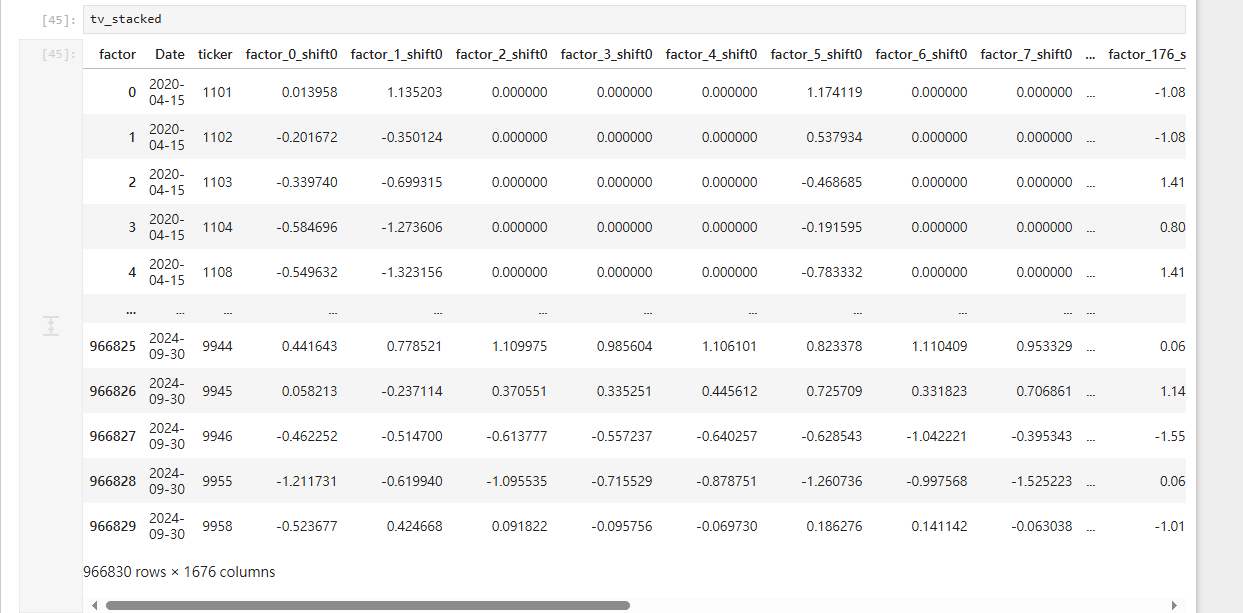

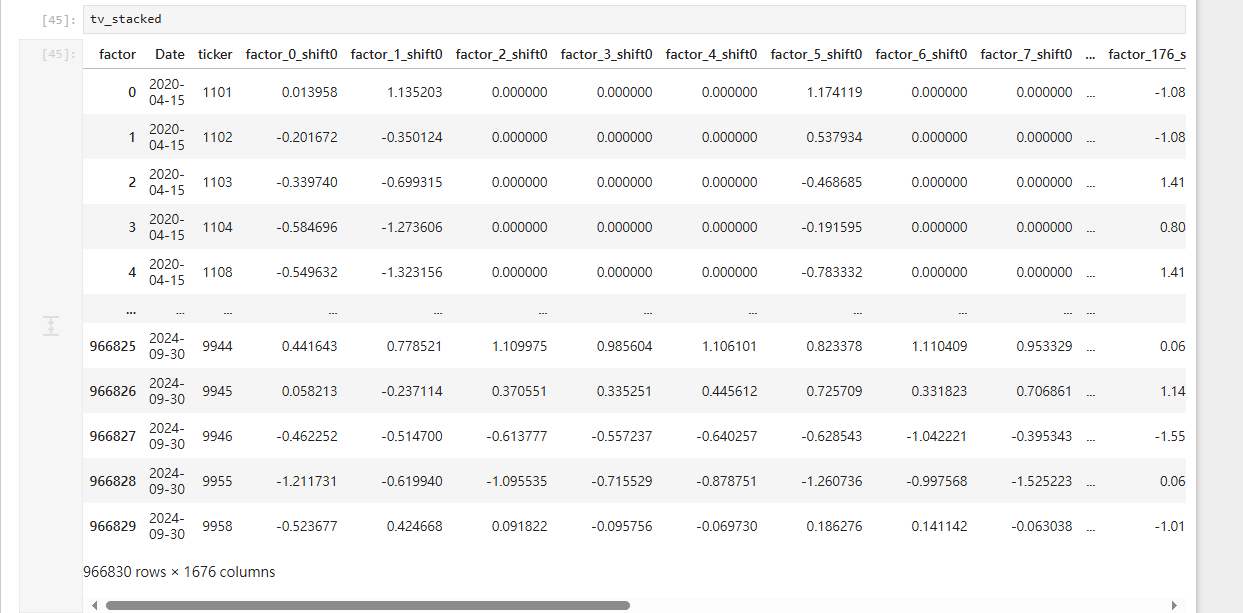

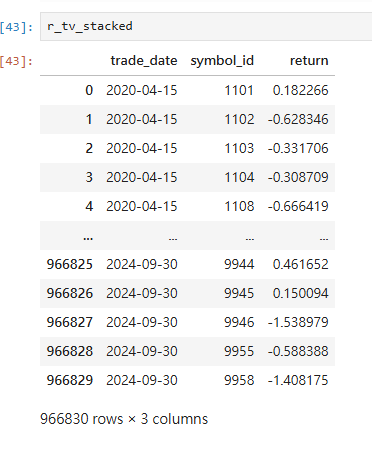

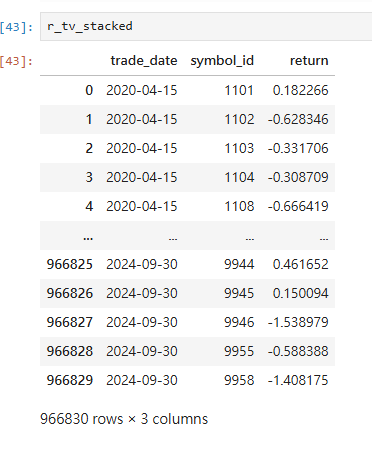

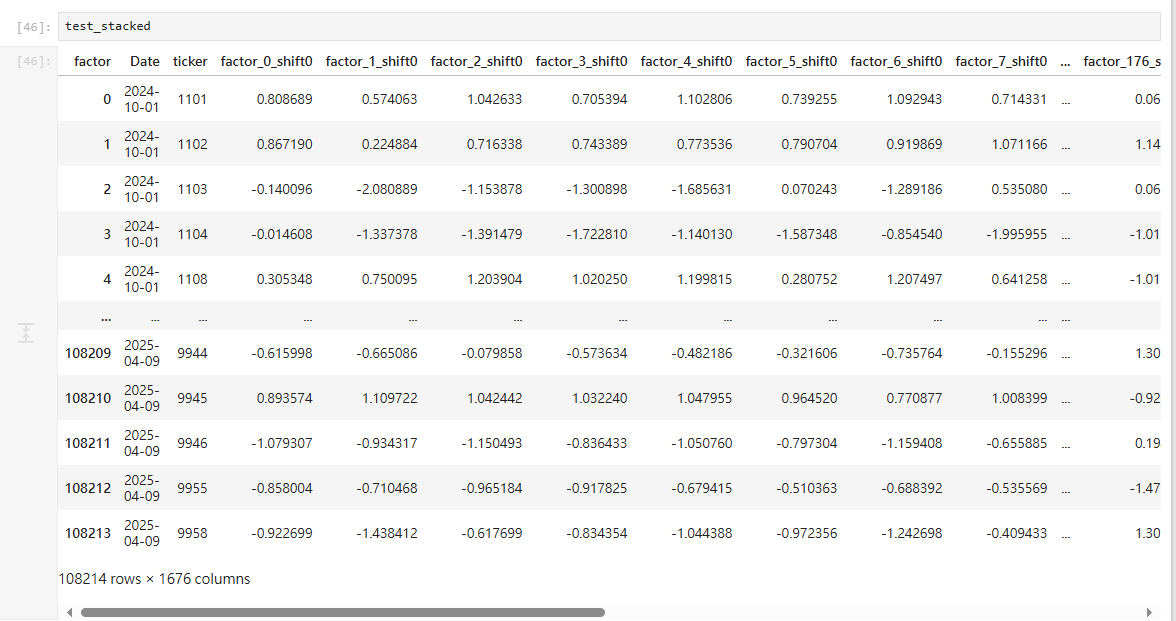

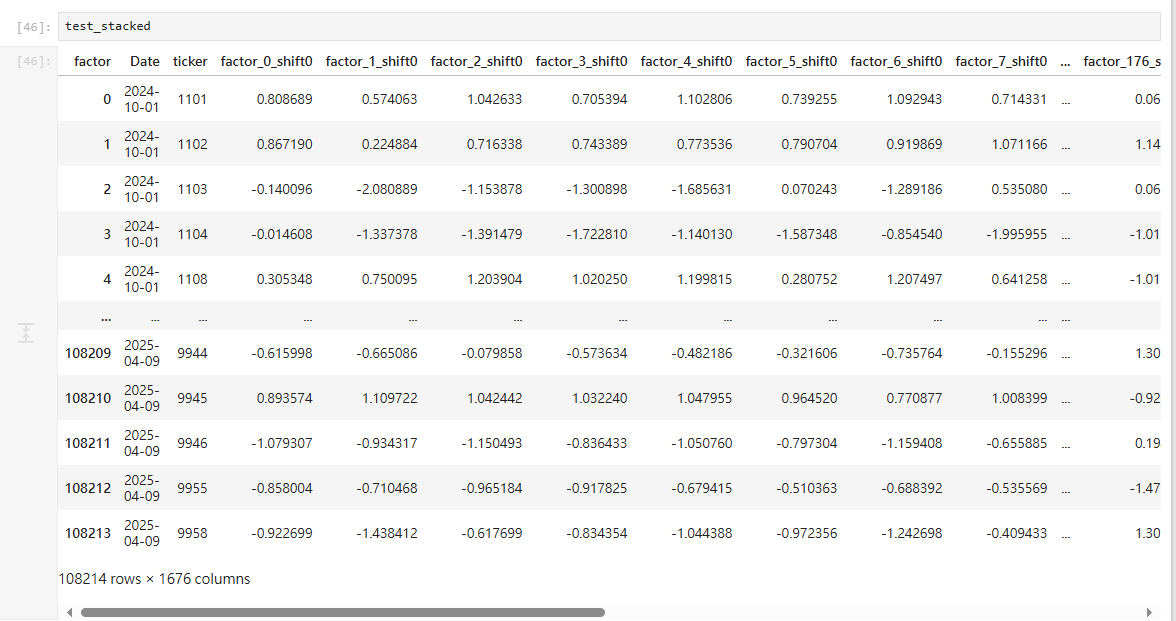

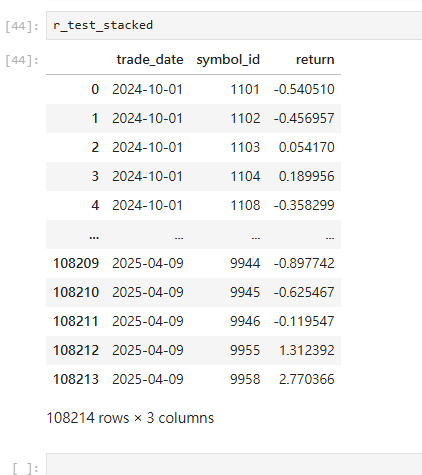

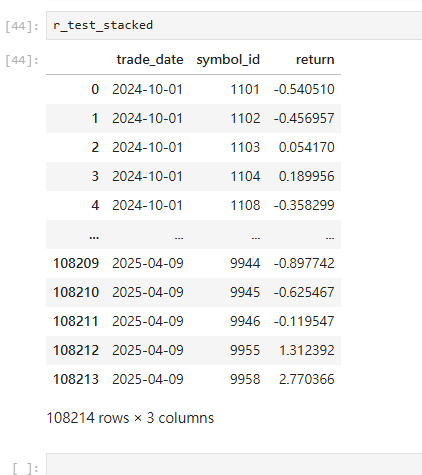

In [ ]:
from xgboost import XGBRegressor
from kneed import KneeLocator
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit

tscv = TimeSeriesSplit(n_splits=10)

for i, (train_idx, val_idx) in enumerate(tscv.split(tv_stacked)):
    X_train, X_val = tv_stacked.iloc[train_idx], tv_stacked.iloc[val_idx]
    y_train, y_val = r_tv_array[train_idx], r_tv_array[val_idx]

    model = XGBRegressor(
        tree_method="hist",
        device="cuda",  # 或 "cpu"
        n_estimators=100,
        learning_rate=0.05,
        max_depth=6,
        random_state=42
    )
    model.fit(X_train, y_train)

    # 特徵重要性
    importances = pd.Series(model.feature_importances_, index=X_train.columns)
    importances_sorted = importances.sort_values(ascending=False)

    # 找 Elbow
    x = list(range(len(importances_sorted)))
    y = importances_sorted.values
    kn = KneeLocator(x, y, curve="convex", direction="decreasing")
    elbow_idx = kn.knee if kn.knee is not None else 10
    top_features = importances_sorted.iloc[:elbow_idx].index.tolist()

    # 畫圖
    plt.figure(figsize=(10, 5))
    plt.plot(x, y, marker='o', markersize=0.1)
    plt.axvline(elbow_idx, color='red', linestyle='--', label=f"Elbow at {elbow_idx}")
    plt.title(f"Fold {i+1} - Feature Importance with Elbow Point")
    plt.xlabel("Feature Rank")
    plt.ylabel("Importance Score")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    print(f"Fold {i+1} Elbow Index: {elbow_idx}")
    print("Selected Features:", top_features)
    # 如果只要畫一張圖，可以加 break
    # break
